# I. Tải và import các thư viện cần thiết

In [1]:
!pip install monai thop pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.6 MB/s eta 0:00:0000:01


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-06-01 05:00:54.248170: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 05:00:54.248304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 05:00:54.364421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!pip install monai

In [4]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-06-01 05:01:44.482784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 05:01:44.482837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 05:01:44.484174: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https

In [28]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle
import cv2

from sklearn.model_selection import train_test_split

from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


# II. Đọc dữ liệu và chia tập train, validation, test

In [29]:
diseases = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass',
 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax',
 'Pulmonary fibrosis']

columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly', 'Consolidation', 'ILD', 'Infiltration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion', 'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis', 'image_id']


In [30]:
def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
    print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df

def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy")) # adjust dicom or png
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df

In [31]:
import pandas as pd

train_data = pd.read_csv("/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv")


class_mapping = train_data[['class_id', 'class_name']].drop_duplicates()

class_mapping = class_mapping.sort_values(by='class_id')

print(class_mapping.to_string(index=False))

disease_labels = class_mapping['class_name'].values
print("Disease LABELS :", disease_labels)
print('-'*100)

print("Now converting into one hot vector format")

train_data['class_id'] = train_data['class_id'].astype(str)

one_hot_encoded = pd.get_dummies(train_data['class_id'])

one_hot_encoded = one_hot_encoded.astype(int)

train_data = pd.concat([train_data, one_hot_encoded], axis=1)

train_data = train_data.groupby('image_id').agg({
    '0': 'max', '1': 'max', '2': 'max', '3': 'max', '4': 'max',
    '5': 'max', '6': 'max', '7': 'max', '8': 'max', '9': 'max',
    '10': 'max', '11': 'max', '12': 'max', '13': 'max', '14': 'max'
}).reset_index()



print("UNIQUE images IN THE DATASET:", len(train_data.image_id.unique()))
print("num rows in dataset  :", len(train_data))

class_counts = train_data.iloc[:, 1:].sum()
print("TOTAL Individual class counts:-\n", class_counts)
print('-'*100)

train_data = train_data.rename(columns=dict(zip(train_data.columns[1:], disease_labels)))
print("Renamed the columns from numbers to disease_label names")


train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')



train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vinbigdata-512-voi-clahe/vinbigdata-512-resized-clahe2-8,8_train')

train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_data, test_size=0.5,random_state=42)

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

train_paths = train_data['file_path'].values
train_labels = train_data[diseases].values

val_paths = val_data['file_path'].values
val_labels = val_data[diseases].values

test_paths = test_data['file_path'].values
test_labels = test_data[diseases].values



print("length of train:", len(train_data), len(train_paths), len(train_labels))
print("length of val:", len(val_data), len(val_data), len(val_data))
print("length of test:", len(test_data), len(test_data), len(test_data))


print("Unique image_ids in train:", len(train_data['image_id'].unique()))
print("Unique image_ids in val:", len(val_data['image_id'].unique()))
print("Unique image_ids in test:", len(test_data['image_id'].unique()))

 class_id         class_name
        0 Aortic enlargement
        1        Atelectasis
        2      Calcification
        3       Cardiomegaly
        4      Consolidation
        5                ILD
        6       Infiltration
        7       Lung Opacity
        8        Nodule/Mass
        9       Other lesion
       10   Pleural effusion
       11 Pleural thickening
       12       Pneumothorax
       13 Pulmonary fibrosis
       14         No finding
Disease LABELS : ['Aortic enlargement' 'Atelectasis' 'Calcification' 'Cardiomegaly'
 'Consolidation' 'ILD' 'Infiltration' 'Lung Opacity' 'Nodule/Mass'
 'Other lesion' 'Pleural effusion' 'Pleural thickening' 'Pneumothorax'
 'Pulmonary fibrosis' 'No finding']
----------------------------------------------------------------------------------------------------
Now converting into one hot vector format
UNIQUE images IN THE DATASET: 15000
num rows in dataset  : 15000
TOTAL Individual class counts:-
 0      3067
1       186
2       452
3

In [32]:
class_counts = train_data.iloc[:, 1:-1].sum()
print("TRAIN Individual class counts:-\n", class_counts)

class_counts = val_data.iloc[:, 1:-1].sum()
print("VAL Individual class counts:-\n", class_counts)

class_counts = test_data.iloc[:, 1:-1].sum()
print("TEST Individual class counts:-\n", class_counts)

TRAIN Individual class counts:-
 Aortic enlargement    2464
Atelectasis            151
Calcification          348
Cardiomegaly          1852
Consolidation          274
ILD                    308
Infiltration           481
Lung Opacity          1039
Nodule/Mass            678
Other lesion           900
Pleural effusion       796
Pleural thickening    1574
Pneumothorax            75
Pulmonary fibrosis    1272
dtype: int64
VAL Individual class counts:-
 Aortic enlargement    301
Atelectasis            16
Calcification          47
Cardiomegaly          238
Consolidation          45
ILD                    38
Infiltration           64
Lung Opacity          141
Nodule/Mass            79
Other lesion          112
Pleural effusion      128
Pleural thickening    204
Pneumothorax            9
Pulmonary fibrosis    162
dtype: int64
TEST Individual class counts:-
 Aortic enlargement    302
Atelectasis            19
Calcification          57
Cardiomegaly          210
Consolidation          34
ILD   

In [33]:
train_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,file_path
0,c5c36ce7f8adbd045bfe59a325eeae47,1,0,0,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,f62a549cbf9dedb3a5990a691bd7c27a,1,0,1,0,0,0,0,0,1,1,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,fbc1bf59ac6832df4802bd8a473d26f4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,1f80202df9f9ee45002ea22f2f29d31f,1,0,1,1,0,0,0,0,0,1,0,0,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,3b37f8d28d0153cedc41acb8020a0a6f,1,0,0,1,0,0,0,1,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


In [34]:
val_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,file_path
0,ccff375f4139cef65b98385224cfc810,1,0,0,0,0,0,0,0,0,1,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,db1942c4b69ecc90ff870f987b7c5284,1,0,1,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,fc50039c45fdb6c9224bfff5ba4e64b3,0,0,0,0,1,1,1,1,1,0,0,1,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,14629917f69e21145d1e662ef6c0dc2e,1,0,0,0,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,5d5a37ba110538a40cbc037126af47d3,1,0,1,0,0,1,0,1,0,1,0,1,0,1,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


In [36]:
test_data.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis,file_path
0,caf1b7af2b0caf57a7ae5d23b5dd2aba,0,0,0,0,0,0,1,1,0,0,1,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
1,e531672ae6083e717cbe83d7fc71ddda,1,0,0,1,0,0,0,0,1,1,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
2,14742737297b34ac440a0338877663ac,1,0,0,1,0,0,0,0,1,1,0,1,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
3,1912296cce436028085697480121b4eb,1,0,0,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...
4,8bc2410a31ef52ddb3e2d41cbe1ea7ff,1,0,0,1,0,0,0,0,0,0,0,0,0,0,/kaggle/input/vinbigdata-512-voi-clahe/vinbigd...


# III. Một số hình minh họa trong bộ dữ liệu

In [37]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files))

3515
439
440


In [38]:
from skimage import exposure

In [39]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)

    clahe_image = exposure.equalize_hist(image)
    
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image


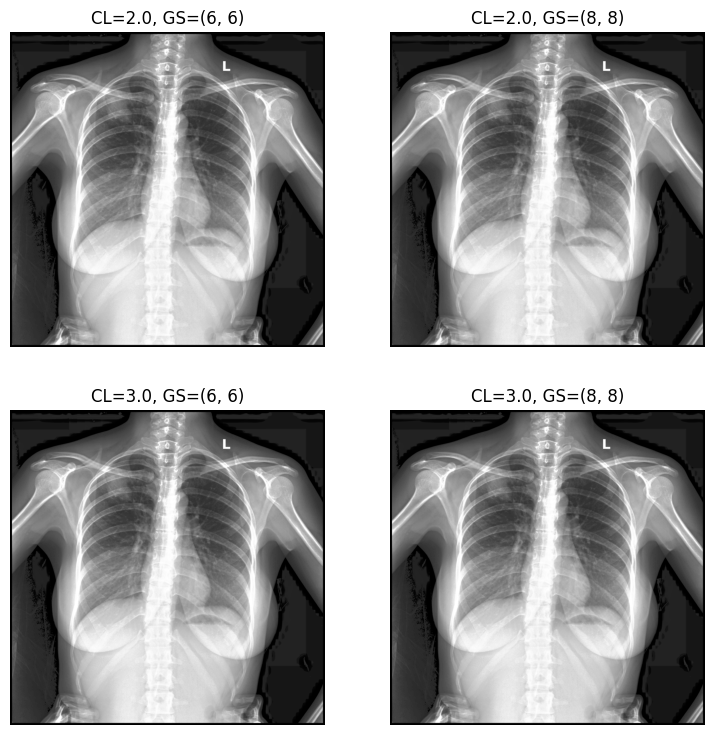

In [40]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


path = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/0005e8e3701dfb1dd93d53e2ff537b6e.dicom'

clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []


for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

In [42]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) 
num_classes = len(train_data.columns) - 2 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes: ", num_classes) 

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes:  14


# IV. Áp dụng các phương pháp tiền xử lý ảnh

In [43]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    return data.astype(np.float32)


train_transforms = Compose(
    [
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
        ScaleIntensity(),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
        ScaleIntensity(),

    ]
)

y_pred_trans = Compose([Activations(sigmoid=True)])
y_trans = Compose([AsDiscrete(threshold_values=True)])

In [44]:
from scipy import ndimage

In [53]:
class VINDR_BigData_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = self.paths[index]
        labels = self.labels[index]
        
        image = np.load(img_path)
        
        # Thay đổi các phương pháp tiền xử lý từ file Preprocessing tại đây
        image = ndimage.gaussian_laplace(image, sigma=1.2)
        # Kết thúc bước thay đổi phương pháp tiền xử lý
        
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, labels


train_ds = VINDR_BigData_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_BigData_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_BigData_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))

No. of TRAIN batches: 440
No. of VAL batches: 55
No. of TEST batches: 55


In [54]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")

    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  

    if torch.cuda.is_available():
        model = model.cuda()

    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")

# V. Xây dựng mô hình

In [55]:
import timm
import torch.nn as nn
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock


class DaViT_UnetR_Modelv2(nn.Module):
    def __init__(self, num_classes, pretrained=True, fine_tune=False):
        super(DaViT_UnetR_Modelv2, self).__init__()
        
        self.davit = timm.create_model('davit_base.msft_in1k', pretrained=pretrained, features_only=True, in_chans=1)
        
        if not fine_tune:
            for param in self.davit.parameters():
                param.requires_grad = False
        
        
        spatial_dims = 2 
        in_channels = 1 # R,G,B
        feature_size = 128
        norm_name = "instance"
        hidden_size = 128
        res_block = True
        conv_block = False

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=1,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size*2,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=1,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size*4,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=1,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=hidden_size * 8,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(feature_size, 78, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(78, 50, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2450, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    
    def forward(self, x_in):
        
        hidden_states_out = self.davit(x_in) # returns 4 lists
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[0]
        enc2 = self.encoder2(x2)
        x3 = hidden_states_out[1]
        enc3 = self.encoder3(x3)
        x4 = hidden_states_out[2]
        enc4 = self.encoder4(x4)
        dec4 = hidden_states_out[3]
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1) 

        conv_out = self.conv(out)

        return self.classifier(conv_out)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DaViT_UnetR_Modelv2(num_classes, fine_tune=False)
model.to(device)

print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output)
display_params_flops(model)


Model output's shape: torch.Size([1, 14])
tensor([[-0.1355,  0.1391, -0.1668, -0.0431,  0.0635,  0.0514,  0.0031,  0.0085,
         -0.1954,  0.0290, -0.2235,  0.2522, -0.0070, -0.0935]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 138.13 M
Number of trainable parameters in millions: 51.21 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.instancenorm.InstanceNorm2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Regis

In [57]:
model = DaViT_UnetR_Modelv2(num_classes, fine_tune=False)
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 3e-5)

## Kết thúc xây dựng mô hình

In [58]:
import torch
import torch.nn as nn

logits = torch.randn(3, num_classes)  
targets = torch.randint(0, 2, (3, num_classes)) 
print(logits)
print(targets)

criterion = nn.BCEWithLogitsLoss()

loss = criterion(logits, targets.float())
print("loss:", loss)

tensor([[ 1.3783,  0.1704, -0.1356, -1.1098, -0.1641,  1.2922, -0.7238,  0.5681,
         -1.3050,  0.0358, -0.3190, -0.3929,  0.2342, -0.1687],
        [-1.1432,  1.5531,  0.0695, -0.9272, -0.8409,  0.1269, -2.0450,  0.9170,
         -1.2475, -0.2604, -0.4461, -0.5665, -0.9045,  0.1720],
        [ 1.6328,  0.5200, -1.1277, -0.1877,  0.2740,  0.6621, -0.7866,  0.2029,
         -0.3749, -0.3543, -0.1809, -1.6828, -0.5098,  1.2947]])
tensor([[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
        [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]])
loss: tensor(0.7696)


In [59]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=20):
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()

    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        model.train()
        start = timer()
        
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
            
            optimizer.zero_grad()

            outputs = model(inputs)

            outputs = outputs.float()
            labels = labels.float()

            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            scores = torch.sigmoid(outputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0) * labels.size(1)
            
            correct_train += (predictions == labels).sum().item()
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
                
        cm = multilabel_confusion_matrix(train_predictions_all, train_labels_all)
        accuracy_arr = []
        precision_arr = []
        recall_arr = []
        f1_arr = []
        
        for i in range(num_classes):
            accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

            precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

            recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
            f1 = (2*precision*recall)/(precision+recall)

            accuracy_arr.append(accuracy)
            precision_arr.append(precision)
            recall_arr.append(recall)
            f1_arr.append(f1)
        
        
        accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
        accuracy_macro_train = round(sum(accuracy_arr) / len(accuracy_arr), 4)
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        roc_auc_macro_train = round(roc_auc_score(train_labels_all, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            model.eval()
        
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.float()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.sigmoid(outputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0) * labels.size(1)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)


            cm = multilabel_confusion_matrix(val_predictions_all, val_labels_all)
            accuracy_arr = []
            precision_arr = []
            recall_arr = []
            f1_arr = []

            for i in range(num_classes):
                accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

                precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

                recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1])
                f1 = (2*precision*recall)/(precision+recall)

                accuracy_arr.append(accuracy)
                precision_arr.append(precision)
                recall_arr.append(recall)
                f1_arr.append(f1)
            
            accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)
            
            accuracy_macro_val = round(sum(accuracy_arr) / len(accuracy_arr), 4)
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)
            roc_auc_macro_val = round(roc_auc_score(val_labels_all, val_scores_all, average='macro'), 4)
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            'time_current_epoch': time_this_epoch
        })
        
        epoch_history = pd.DataFrame(history_list)

        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
        print('history should be saved')
        
        
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

# VI. Huấn luyện mô hình

In [60]:
 history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=10,
          ranOnce=False,
         save_interval=10)

Starting afresh!


100%|██████████| 440/440 [03:27<00:00,  2.12it/s]
/tmp/ipykernel_34/1942031102.py:106: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 1/10
Training Loss: 0.4690, Accuracy: 0.7847
correct: 38617  out of  49210
MACRO-averged metrics:- accuracy: 0.7847, precision: 0.2423, recall: 0.1505, f1: 0.1461, ROC_AUC: 0.5262


100%|██████████| 55/55 [00:14<00:00,  3.85it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4492, Accuracy: 0.7947
correct: 4884  out of  6146
MACRO-averged metrics:- accuracy: 0.7947, precision: 0.1922, recall: 0.1456, f1: 0.1485, ROC_AUC: 0.6473
Time_for_this_epoch: 221.7848 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 2/10
Training Loss: 0.4327, Accuracy: 0.8048
correct: 39603  out of  49210
MACRO-averged metrics:- accuracy: 0.8048, precision: 0.3889, recall: 0.1833, f1: 0.1922, ROC_AUC: 0.6472


100%|██████████| 55/55 [00:14<00:00,  3.87it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4303, Accuracy: 0.8044
correct: 4944  out of  6146
MACRO-averged metrics:- accuracy: 0.8044, precision: 0.3061, recall: 0.185, f1: 0.1889, ROC_AUC: 0.7032
Time_for_this_epoch: 220.5933 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 3/10
Training Loss: 0.4159, Accuracy: 0.8141
correct: 40060  out of  49210
MACRO-averged metrics:- accuracy: 0.8141, precision: 0.3653, recall: 0.2073, f1: 0.2242, ROC_AUC: 0.6936


100%|██████████| 55/55 [00:14<00:00,  3.86it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4180, Accuracy: 0.8090
correct: 4972  out of  6146
MACRO-averged metrics:- accuracy: 0.809, precision: 0.3136, recall: 0.1997, f1: 0.2113, ROC_AUC: 0.7158
Time_for_this_epoch: 220.6342 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 4/10
Training Loss: 0.4016, Accuracy: 0.8201
correct: 40358  out of  49210
MACRO-averged metrics:- accuracy: 0.8201, precision: 0.4013, recall: 0.2232, f1: 0.2443, ROC_AUC: 0.7265


100%|██████████| 55/55 [00:14<00:00,  3.88it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4132, Accuracy: 0.8150
correct: 5009  out of  6146
MACRO-averged metrics:- accuracy: 0.815, precision: 0.3879, recall: 0.1984, f1: 0.2258, ROC_AUC: 0.7265
Time_for_this_epoch: 221.0211 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 5/10
Training Loss: 0.3889, Accuracy: 0.8258
correct: 40639  out of  49210
MACRO-averged metrics:- accuracy: 0.8258, precision: 0.439, recall: 0.2376, f1: 0.2649, ROC_AUC: 0.7512


100%|██████████| 55/55 [00:14<00:00,  3.89it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4076, Accuracy: 0.8142
correct: 5004  out of  6146
MACRO-averged metrics:- accuracy: 0.8142, precision: 0.3491, recall: 0.2198, f1: 0.2418, ROC_AUC: 0.7314
Time_for_this_epoch: 220.7524 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 6/10
Training Loss: 0.3751, Accuracy: 0.8331
correct: 40995  out of  49210
MACRO-averged metrics:- accuracy: 0.8331, precision: 0.5011, recall: 0.2597, f1: 0.2927, ROC_AUC: 0.7777


100%|██████████| 55/55 [00:14<00:00,  3.88it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4075, Accuracy: 0.8126
correct: 4994  out of  6146
MACRO-averged metrics:- accuracy: 0.8126, precision: 0.4474, recall: 0.2453, f1: 0.2678, ROC_AUC: 0.729
Time_for_this_epoch: 221.0207 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 7/10
Training Loss: 0.3593, Accuracy: 0.8402
correct: 41344  out of  49210
MACRO-averged metrics:- accuracy: 0.8402, precision: 0.5383, recall: 0.283, f1: 0.3222, ROC_AUC: 0.8005


100%|██████████| 55/55 [00:14<00:00,  3.90it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_34/1942031102.py:184: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4023, Accuracy: 0.8166
correct: 5019  out of  6146
MACRO-averged metrics:- accuracy: 0.8166, precision: 0.3782, recall: 0.2616, f1: 0.2866, ROC_AUC: 0.7352
Time_for_this_epoch: 220.5285 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 8/10
Training Loss: 0.3435, Accuracy: 0.8475
correct: 41707  out of  49210
MACRO-averged metrics:- accuracy: 0.8475, precision: 0.5742, recall: 0.3086, f1: 0.3523, ROC_AUC: 0.8215


100%|██████████| 55/55 [00:14<00:00,  3.88it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_34/1942031102.py:184: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4049, Accuracy: 0.8179
correct: 5027  out of  6146
MACRO-averged metrics:- accuracy: 0.8179, precision: 0.4353, recall: 0.2626, f1: 0.2952, ROC_AUC: 0.7355
Time_for_this_epoch: 221.1336 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.13it/s]
/tmp/ipykernel_34/1942031102.py:103: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 9/10
Training Loss: 0.3234, Accuracy: 0.8573
correct: 42189  out of  49210
MACRO-averged metrics:- accuracy: 0.8573, precision: 0.6496, recall: 0.3493, f1: 0.4009, ROC_AUC: 0.8473


100%|██████████| 55/55 [00:14<00:00,  3.91it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_34/1942031102.py:184: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.4072, Accuracy: 0.8174
correct: 5024  out of  6146
MACRO-averged metrics:- accuracy: 0.8174, precision: 0.405, recall: 0.2683, f1: 0.2975, ROC_AUC: 0.7354
Time_for_this_epoch: 220.3445 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 440/440 [03:26<00:00,  2.14it/s]
/tmp/ipykernel_34/1942031102.py:106: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 10/10
Training Loss: 0.3021, Accuracy: 0.8670
correct: 42665  out of  49210
MACRO-averged metrics:- accuracy: 0.867, precision: 0.6453, recall: 0.3868, f1: 0.4435, ROC_AUC: 0.8693


100%|██████████| 55/55 [00:14<00:00,  3.88it/s]
/tmp/ipykernel_34/1942031102.py:181: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.4204, Accuracy: 0.8062
correct: 4955  out of  6146
MACRO-averged metrics:- accuracy: 0.8062, precision: 0.47, recall: 0.3397, f1: 0.363, ROC_AUC: 0.7224
Time_for_this_epoch: 220.2596 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 10


# VII. Đánh giá kết quả trên tập test

In [61]:
history_path = '/kaggle/working/history.csv'
history = pd.read_csv(history_path)

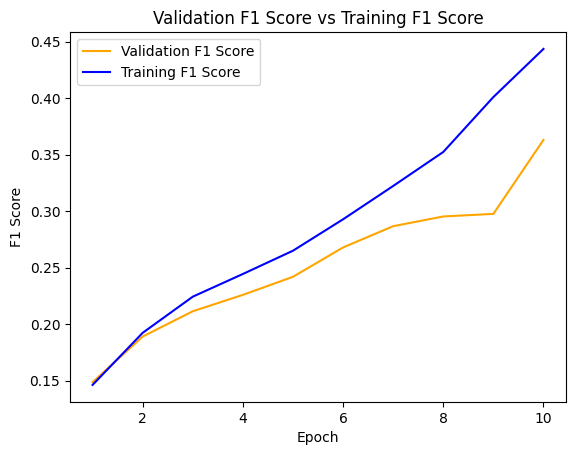

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

plt.plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
plt.plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score vs Training F1 Score')
plt.legend()

In [63]:
model_path = '/kaggle/working/best_model_f1.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [64]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


with torch.no_grad():
    model.eval()

    start = timer()
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()


        scores = torch.sigmoid(outputs)
        predictions = torch.sigmoid(outputs) > 0.5
        total_test += labels.size(0) * labels.size(1)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=diseases, digits=4)) # adjust the target_names

    cm = multilabel_confusion_matrix(test_predictions_all, test_labels_all)
    accuracy_arr = []
    precision_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(num_classes):
        print(cm[i])
        print(cm[i].sum())

        accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

        precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

        recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1])
        f1 = (2*precision*recall)/(precision+recall)
        print(disease_labels[i],": ",round(accuracy*100,2),"%")
        print("Precision: ",round(precision,2))
        print("Recall:", round(recall,2))
        print("F1-Score:", round(f1,2))
        print('==========================================================')


        accuracy_arr.append(accuracy)
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)
    
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
            
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
    
    accuracy_macro_test = round(sum(accuracy_arr) / len(accuracy_arr), 4)
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)
    roc_auc_macro_test = round(roc_auc_score(test_labels_all, test_scores_all, average='macro'), 4)

    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 55/55 [00:15<00:00,  3.66it/s]

Accuracy: 0.8115
correct: 4999  out of  6160
                    precision    recall  f1-score   support

Aortic enlargement     0.8052    0.9305    0.8633       302
       Atelectasis     1.0000    0.0526    0.1000        19
     Calcification     0.0000    0.0000    0.0000        57
      Cardiomegaly     0.7619    0.8381    0.7982       210
     Consolidation     0.3333    0.0588    0.1000        34
               ILD     0.6667    0.1000    0.1739        40
      Infiltration     0.5185    0.2059    0.2947        68
      Lung Opacity     0.5405    0.5634    0.5517       142
       Nodule/Mass     0.3696    0.2464    0.2957        69
      Other lesion     0.4590    0.2295    0.3060       122
  Pleural effusion     0.6105    0.5370    0.5714       108
Pleural thickening     0.5543    0.7537    0.6388       203
      Pneumothorax     0.0000    0.0000    0.0000        12
Pulmonary fibrosis     0.5783    0.5246    0.5501       183

         micro avg     0.6445    0.5800    0.6105    


/tmp/ipykernel_34/974893347.py:53: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
